![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/jupyter/Cards/SparkOcrImageTableRecognitionWHOCR.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

In [1]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Saving spark-license-v430.json to spark-license-v430.json


In [7]:
%pip install transformers

# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.johnsnowlabs.com/4.3.0-9c0f1a7c57f6ef6bb9153c66f61ae94ca5dcdd34


<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [8]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [9]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 4.2.4
Spark OCR version: 4.3.0



## Printed source
### Read images and display it


    Image #0:
    Origin: file:/content/table4_1.jpg
    Resolution: 0 dpi
    Width: 1000 px
    Height: 1095 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


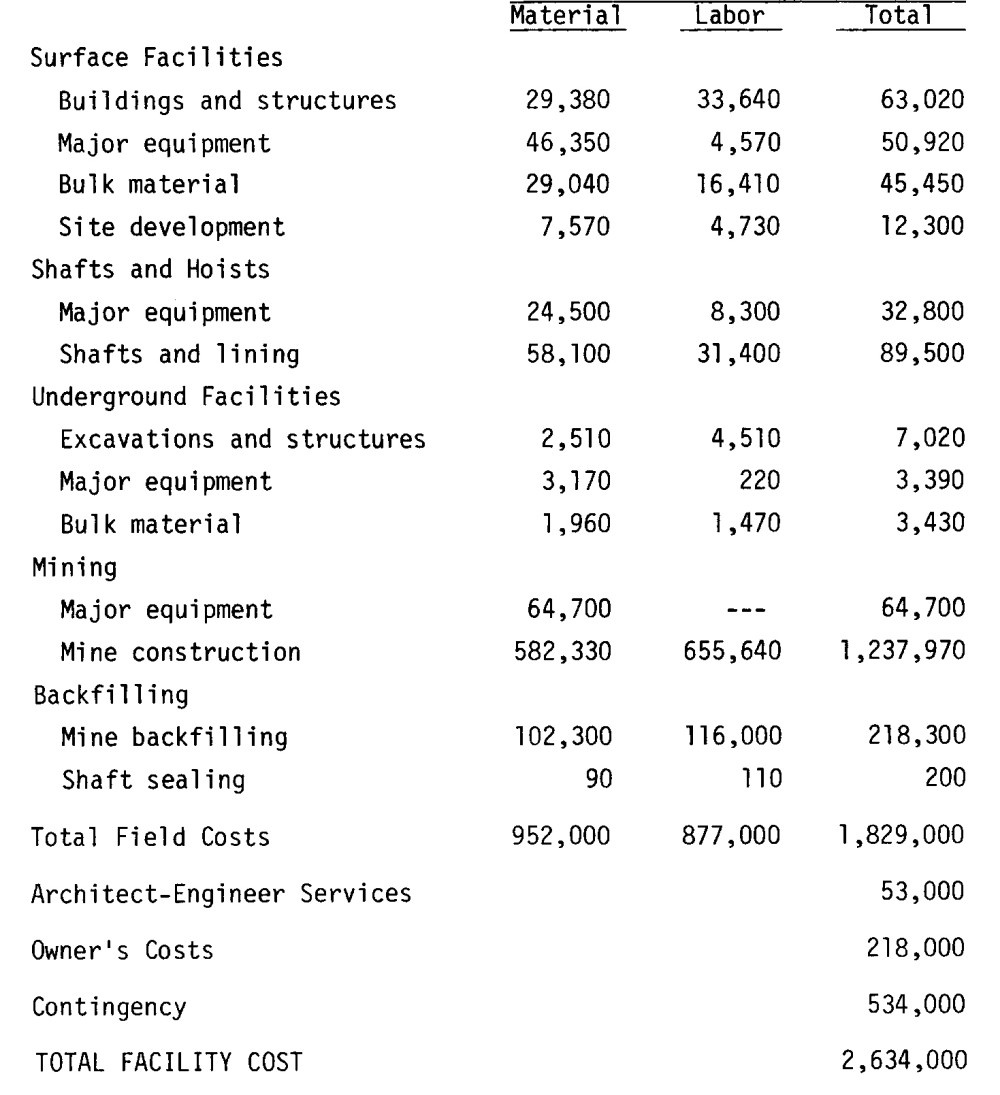

In [11]:
imagePath = "data/tab_images_hocr_1/table4_1.jpg"
image_df= spark.read.format("binaryFile").load(imagePath)
display_images(BinaryToImage().transform(image_df), "image")

In [12]:
binary_to_image = BinaryToImage()

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions")

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image") \
    .setImageType(ImageType.TYPE_BYTE_GRAY) \
    .setExplodeCols([])

text_detector = ImageTextDetectorV2.pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

img_to_hocr = ImageToTextV2().pretrained("ocr_small_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setUsePandasUdf(False) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setOutputCol("hocr") \
    .setGroupImages(False)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setRegionCol("table_regions") \
    .setOutputCol("tables")

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

result = pipeline.transform(image_df).cache()
display(result)

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB
image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB


text_regions,table_image,pagenum,modificationTime,path,table_regions,length,image,image_with_regions,hocr,tables,exception,table_index
"[{0, 0, 566.32025...",{file:/content/ta...,0,2023-01-23 08:21:...,file:/content/tab...,"{0, 0, 40.0, 0.0,...",172124,{file:/content/ta...,{file:/content/ta...,"<?xml version=""1....","{{0, 0, 0.0, 0.0,...",null,0


### Show text regions


    Image #0:
    Origin: file:/content/table4_1.jpg
    Resolution: 0 dpi
    Width: 1000 px
    Height: 1095 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


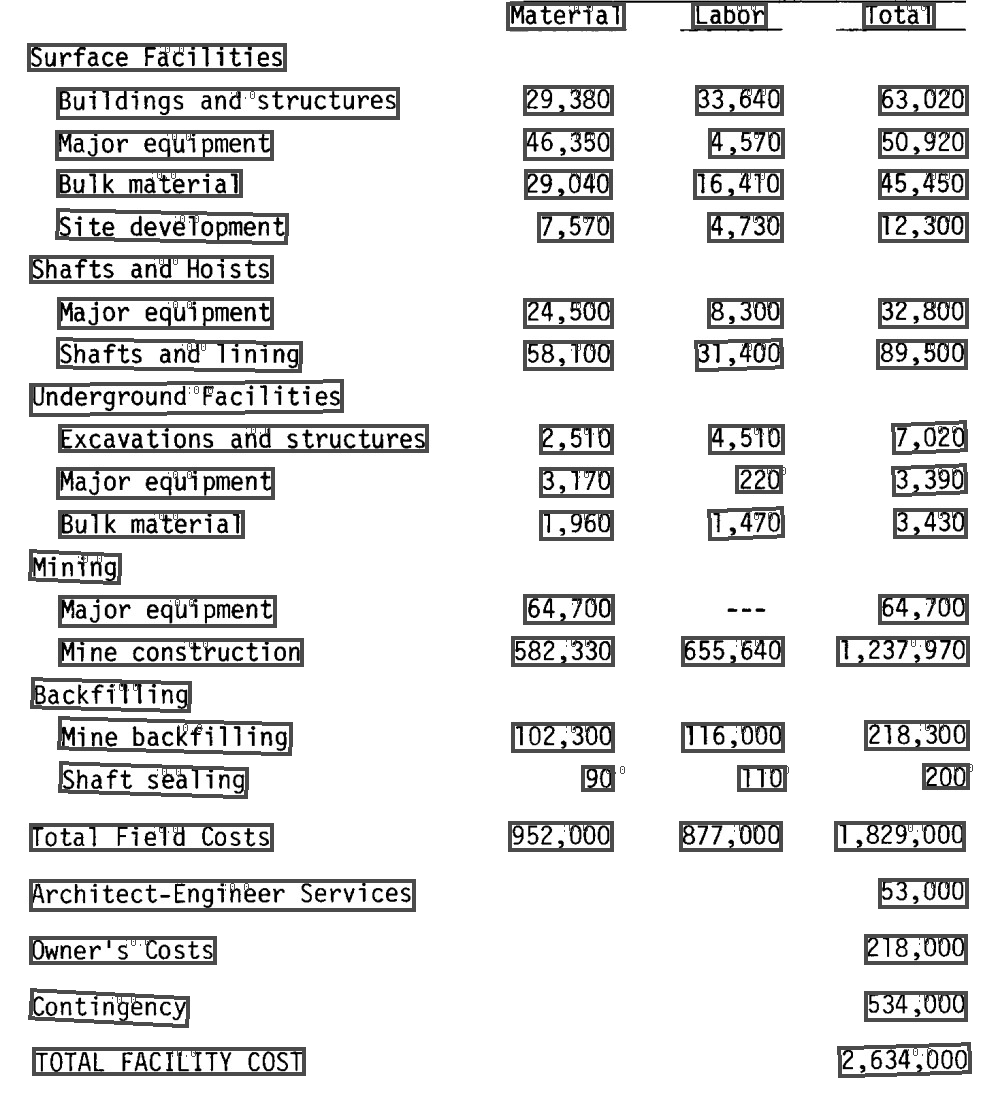

In [13]:
display_images(result, "image_with_regions")

### Show images with tables


    Image #0:
    Origin: file:/content/table4_1.jpg
    Resolution: 0 dpi
    Width: 937 px
    Height: 1093 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


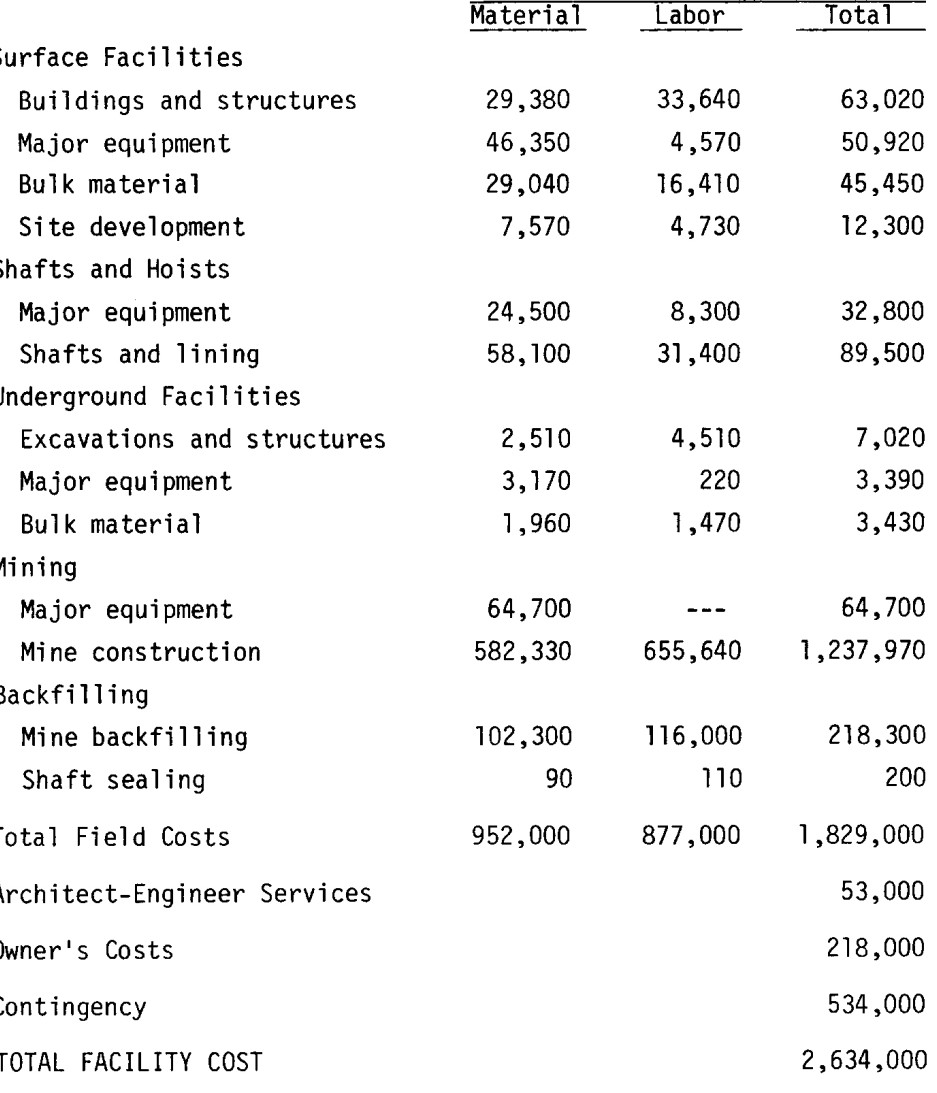

In [14]:
display_images(result, "table_image")

### Display recognized tables

In [15]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: table4_1.jpg
Page:     0
Table:    0
4


,col0,col1,col2,col3
0,,MATERIAL,LABOR,TOTAL
1,SURFACE FACILITIES,None,None,None
2,BUILDINGS AND STRUCTURES,"29,380","33,640","63,020"
3,MAJOR EQUIPMENT,"46,350","4,570","50,920"
4,BULK MATERIAL,"29,040","16,410","45,450"
5,SITE DEVELOPMENT,"7,570","4,730","12,300"
6,SHAFTS AND HOISTS,None,None,None
7,MAJOR EQUIPMENT,"24,500","8,300","32,800"
8,SHAFTS AND LINING,"58,100","31,400","89,500"
9,UNDERGROUND FACILITIES,None,None,None


## Handwritten source

In [16]:
imagePath_2 = "data/tab_images_hocr_2/cTDaR_t00192.jpg"
image_df_2 = spark.read.format("binaryFile").load(imagePath_2)#.limit(1)
display_images(BinaryToImage().transform(image_df_2), "image")

Output hidden; open in https://colab.research.google.com to view.

In [17]:
img_to_hocr_handwritten = ImageToTextV2().pretrained("ocr_small_handwritten", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setUsePandasUdf(False) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setOutputCol("hocr") \
    .setGroupImages(False)

pipeline_2 = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr_handwritten,
    hocr_to_table
])

result_2 = pipeline.transform(image_df_2).cache()
display(result_2)

ocr_small_handwritten download started this may take some time.
Approximate size to download 139.9 MB


text_regions,table_image,length,modificationTime,table_regions,pagenum,path,image,image_with_regions,hocr,tables,exception,table_index
"[{0, 0, 979.1998,...",{file:/content/cT...,4786163,2023-01-23 08:24:...,"{0, 0, 140.0, 106...",0,file:/content/cTD...,{file:/content/cT...,{file:/content/cT...,"<?xml version=""1....","{{0, 0, 0.0, 0.0,...",null,0


In [18]:
display_tables(result_2, table_col = "tables", table_index_col = "table_index")

Filename: cTDaR_t00192.jpg
Page:     0
Table:    0
10


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9
0,,NO NO. 49 TOTAL LOTAL TOTAL,,,,,,,,
1,MOVING,None,None,None,None,None,None,None,None,None
2,MOVING,GST EXCORD SHOT SNOWABLE,None,None,None,None,None,None,None,None
3,1794,None,None,None,None,None,None,None,None,None
4,9.99,16,,16,,,,439,None,None
5,9.99,16 52,,16,,,TOTAL FOR TUOLVER KASHEL,439,None,None
6,1795,None,None,None,None,None,None,None,None,None
7,CLAY,,,,,421,None,None,None,None
8,CLAY,,,,,421,None,None,None,None
9,3969,,,,,410,None,None,None,None
